### Objective

Your task is to extract a set of prosodic correlates (i.e. suprasegmental speech parameters) and cepstral features from speech recordings. Then, an emotion recognition system is constructed to recognize happy versus sad emotional speech (a quite easy two class problem) using a simple supervised classifier training and testing structure.

The original speech data is a set of simulated emotional speech (i.e. acted) from ten speakers speaking five different pre-segmented sentences of roughly 2-3 seconds in two different emotional states (happy and sad) totaling 100 samples.
Basic prosodic features (i.e. distribution parameters derived from the prosodic correlates) are extracted using a simple voiced/unvoiced analysis of speech, pitch tracker, and energy analysis. Another set of Mel-Frequency Cepstral Coefficients (MFCC) features are also calculated for comparison. 

Support Vector Machine (SVM) classifiers are trained. A random subset of 1/2 of the available speech data (i.e. half of the persons) is used to train the emotion recognition system, first using a set of simple prosodic parameter features and a then a classical set of MFCC derived features. The rest of the data (the other half of the persons) is then used to evaluate the performances of the trained recognition systems.

<!--### Implementation
<!---The data and toolbox files used in this exercise are:
Study the toolbox functions (e.g. ‘getF0’, ‘melcepst’) and the generic MATLAB functions (e.g. ‘hamming’, ‘conv’, ‘resample’, ‘filter’, ‘mean’, ‘std’, ‘prctile’, ‘kurtosis’, ‘sum’, ‘length’, ‘linspace’, ‘trainsvm’, ‘svmclassify’, and ‘confusionmat’) as they are needed in the exercise.-->

<!--Nine dictionaries are stored in the provided data file:-->

<!--* speech_sample
* testing_class 
* testing_data_mfcc 
* testing_data_proso 
* testing_personID 
* training_class 
* training_data_mfcc 
* training_data_proso 
* training_personID -->

<!--To access one dictionary, using [`scipy.io`](https://docs.scipy.org/doc/scipy/reference/io.html) library for example: scipy.io.loadmat('filePath')['dictoionaryName']. **speech_sample** is used in the feature extraction part and the pre-extracted features in the emotion recognition part of this lab are **testing_class**, **testing_data_mfcc**, **testing_personID**, **training_class**, **training_data_mfcc**, **training_data_proso**, **training_personID**.-->


## Task 0. Preparation
Downsample the ‘speech_sample’ from the original Fs of 48 kHz to 11.025 kHz using [`scipy.signal.resample()`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.resample.html) function.

**Steps**:
1. Load the data 'speech_sample' from file *lab2_data.mat*. Make sure the sample is a 1-D time series by reshaping it.
2. Declare the sampling frequency of the original signal, and the new sampling frequency.
3. Resample the signal using [`scipy.signal.resample()`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.resample.html).
4. Visualize the resampled signal in the time domain. Use an appropriate time vector as the x-axis.

<!--### Task 0.1. Load Data
Load the ‘speech_sample’ from the provided dataset containing a raw speech waveform and do the following (Note, the sampling rate (fs) of the sample speech signal is 48 kHz):-->

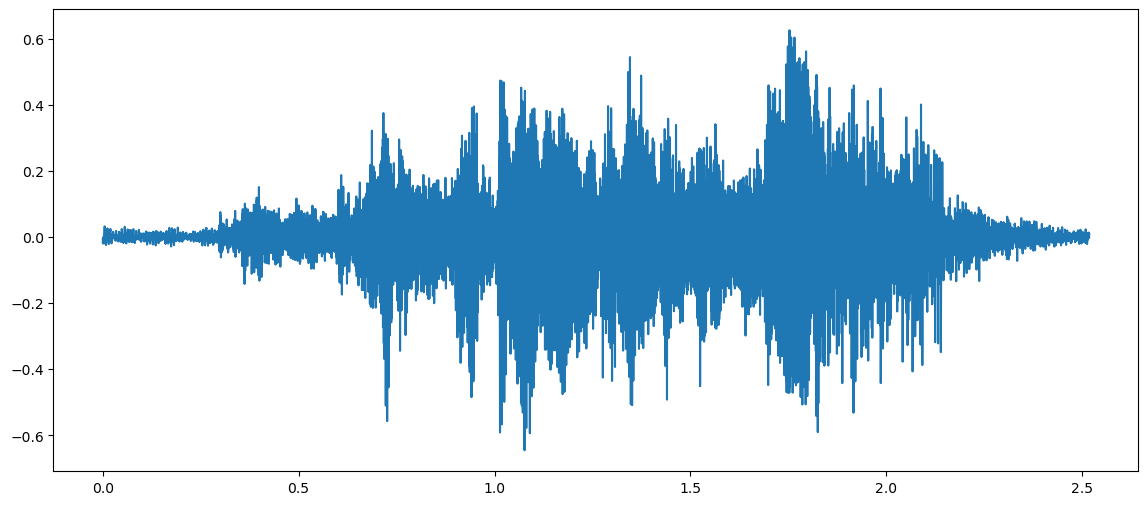

In [11]:
import numpy as np
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt

# 1. Load the 'speech_sample'
exercise_data = sio.loadmat('lab2_data.mat')
speech_sample = exercise_data['speech_sample'].reshape(-1)
# print(len(speech_sample.shape))

# speech_len = len(speech_sample)

# 2. Declare the source sampling frequency, and the target sampling frequency.
#    2.1 Source sampling frequency
fs_source =  48000

#    2.2 Target sampling frequency
# Target frequency
fs_down = 11025

# Calculating the resampling factor
resampling_factor = fs_down / fs_source

# Calculating the new length of the resampled speech
new_length = int(len(speech_sample) * resampling_factor)

# 3. Downsample the speech sample
speech_resampled = signal.resample(speech_sample,new_length)


# 4. Visualize the downsampled speech signal in the time domain.
#    4.1 Create the corresponding time vector, whose length is the same as the length of the given signal. 
#        Use either np.linspace() or np.arange()
time_source = np.arange(len(speech_sample)) / fs_source
time_down = np.arange(new_length) / fs_down

#    4.2 Plot your result
plt.figure(figsize=(14, 6))
plt.plot(time_down, speech_resampled)
plt.show()

## Task 1. Feature Extraction

### Task 1.1 MFCC calculations using the provided sample speech signal.

**Steps**:
1. Pre-emphasize the resampled signal by applying a high pass filter, using the [`scipy.signal.lfilter()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) function.
   Apply a pre-emphasis filter $ H(z) = 1- \alpha z^{-1} $ with $\alpha = 0.98$ to emphasize higher frequencies in your downsampled speech signal (Tip: use [`scipy.signal.lfilter`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.lfilter.html)). 
   
   Hint for defining the filter: you will provide two vectors **b** and **a** to define the filter, **a** for the denominator and **b** for the numerator. So finally your filter will be defined as $$H(z) = \frac{b[0] z^0 + b[1] z^{-1} + ... + b[i] z^{-i}+...}{a[0] z^0 + a[1] z^{-1} + ... + a[i] z^{-i}+...}$$
2. Extract the 12 mfcc coefficients by using the [`python_speech_features.mfcc()`](http://python-speech-features.readthedocs.io/en/latest/) function.
    1. **The [`python_speech_features.mfcc()`](http://python-speech-features.readthedocs.io/en/latest/) function has an internal pre-emphasis functionality. However, we calculate the pre-emphasis by hand in order to have a better understanding of it, and thus it should be set to 0** 
3. Visualize the 12 mfcc coefficient contours.
4. Calculate the mean of each contour using [`numpy.mean(axis=axis)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html).

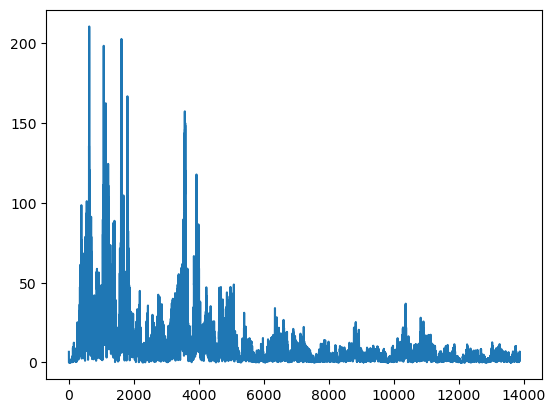

In [2]:
from scipy.fftpack import fft
plt.plot(abs(fft(speech_resampled))[:int(len(speech_resampled)/2)])

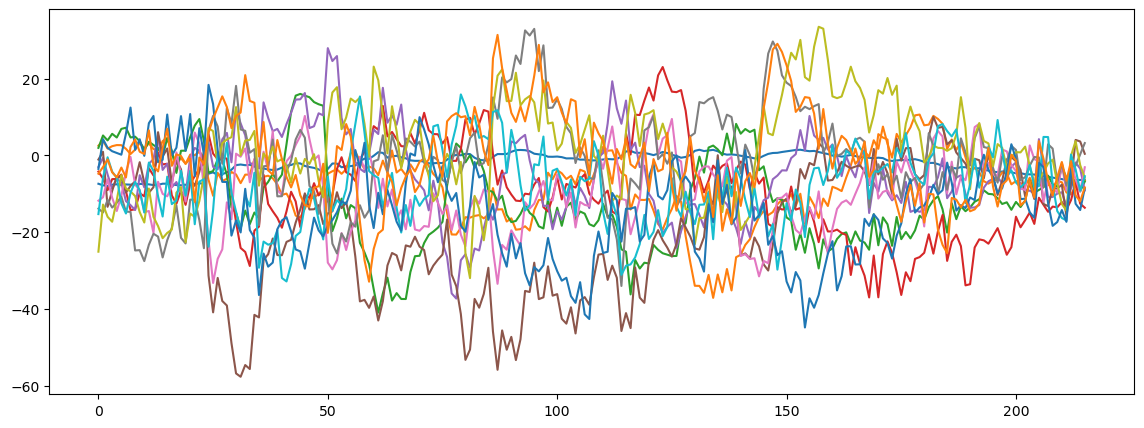

Mean of each contour:
[ -2.17031911  -7.57536788 -11.54300249  -9.23687878  -5.0647505
 -19.07163611  -9.45254527  -0.95624205   1.60418387  -7.87867908
 -13.98430176  -0.68474208]


In [3]:
from scipy.signal import lfilter
from python_speech_features import mfcc
# 1. Pre-emphasize the resampled signal.
#    1.1 Define the polynomials of the filter
#        filter coefficients b, which is the numerator
#        filter coefficients a, which is the denominator
b = [1, -0.98]
a = [1]

#    1.2 Apply the filter on the signal
pre_emphasized_sample = lfilter(b,a,speech_resampled)

# 2. Extract the mfcc coefficients by using the mfcc() function
     # remeber to set the pre-emphasize argument to 0 since the signal has been pre-emphasized already.
frame_len = int(2 ** np.floor(np.log2(0.03 * fs_down)))
mfcc_contour = mfcc(pre_emphasized_sample, 
                   fs_down, 
                   winlen = frame_len / fs_down, 
                   winstep = frame_len / (2 * fs_down), 
                   numcep = 12, 
                   preemph = 0)

# 3. Plot the 12 mfcc contours
plt.figure(figsize=(14, 5))
for i in range(12):
    plt.plot(mfcc_contour[:, i])
plt.show()

# 4. Calculate the mean for each contour.
mean_contours = np.mean(mfcc_contour, axis=0)

print("Mean of each contour:")
print(mean_contours)

### Question 1. Why do we need to pre-emphasize the speech signal before computing the MFCC feature?

### Your answer:

In speech signals, lower-frequency components typically have higher amplitudes compared to higher-frequency components. By applying pre-emphasis, we boost the energy of the higher-frequency components relative to the lower-frequency components, which helps to balance the spectrum. This equalization improves the numerical stability of subsequent signal processing steps.

### Task 1.2 Extract the Intensity/Energy parameter
Firstly, calculate the short time energy (STE) of the downsampled ‘speech_sample’ using the squared signal $x(t)^2$ and a 0.01s hamming window frames (Note! the extra length of the window. Clip half a window length from the beginning and at the end). Then calculate the 5 distribution parameter features specified below from the utterance (the signal).


**Steps**:
1. Define a hamming window using the [`scipy.signal.hamming()`](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.hamming.html) function. The window length is the number of frames in 0.01s.

2. Apply the hamming window to convolve the squared signal, using the [`scipy.signal.convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) function. The convolution result is the short time energy (STE) controu.
3. Clip half window of frames from the begining and ending of STE contour.
4. Visualize the resulted STE controur.
5. Calculating the following 5 distribution parameter feature from the STE contour:
    1. Mean, using the [`numpy.mean(https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.mean.html)`]() function.
    2. Standard Deviation (SD), using the [`numpy.std()`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.std.html) function.
    3. 10% percentile, using the [`numpy.percentile()`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.percentile.html) function.
    4. 90% percentile, using the [`numpy.percentile()`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.percentile.html) function.
    5. Kurtosis, using the [`scipy.stats.kurtosis()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) function.


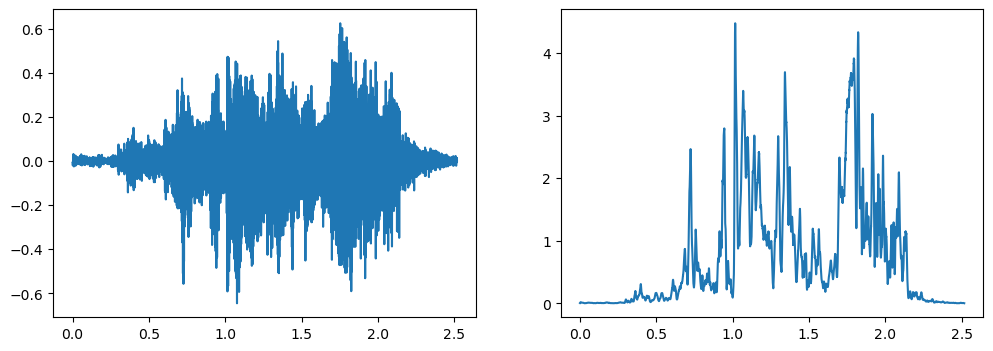

Features from STE:
Mean: 0.7478939418272473
Std: 0.9053540180484816
10th Percentile: 0.007385026020143311
90th Percentile: 2.0804784590183805
Kurtosis: 1.9381567028020648


In [4]:
from scipy.stats import kurtosis
from scipy.signal import hamming, convolve
# 1. Define a hamming window
#    1.1 Calculate the window length, which is the number of frames within 0.01s
hamming_length = int(0.01 * fs_down)

#    1.2 Define the hamming window using signal.hamming()
hamming_window = hamming(hamming_length)

# 2. Calculate the short time energy (STE) contour by convolving the hamming window and the squared signal, 
#    using the scipy.signal.convolve() function
ste = convolve(speech_resampled ** 2, hamming_window)

# 3. Clip half a window of frames from both the beginning and end of the STE contour
ste = ste[int(hamming_length / 2):-int(hamming_length / 2) - 1]

# 4. Visualize the final STE contour.
#    4.1 Create the time vector for x-axis
time_vector_ste = np.arange(len(ste)) / fs_down

#    4.2 Visualize speech_resampled and the STE contour
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(time_down, speech_resampled)

plt.subplot(1, 2, 2)
plt.plot(time_vector_ste, ste)
plt.show()

# 5. Calculate the 5 distribution parameter features the of STE contour
mean_ste = np.mean(ste)
std_deviation_ste = np.std(ste)
percentile_10_ste = np.percentile(ste, 10)
percentile_90_ste = np.percentile(ste, 90)
kurtosis_ste = kurtosis(ste)

print("Features from STE:")
print("Mean:", mean_ste)
print("Std:", std_deviation_ste)
print("10th Percentile:", percentile_10_ste)
print("90th Percentile:", percentile_90_ste)
print("Kurtosis:", kurtosis_ste)

### Question 2. Why do we need to clip out half a frame from both the beginning and the ending of the STE?

### Your answer:

Clipping out half a frame from the beginning and the end of the STE contour is a standard practice to enhance the accuracy and reliability of the energy estimation when using window functions to analyze short segments of the signal. It helps mitigate the effects of windowing and edge artifacts, resulting in a more meaningful representation of the signal's energy content.

### Task 1.3. Extract the Pitch/F0 feature
**Steps**:
1. Extract the Pitch/F0 contour of the resampled speech signal using the **get_f0()** function in 0.01s frames. The function is provided in the *f0_lib.py* file.
2. Visualize the F0 contour.
3. Extract the 5 distribution parameter features of the extracted F0 countour.



In [5]:
import warnings
warnings.filterwarnings("ignore")

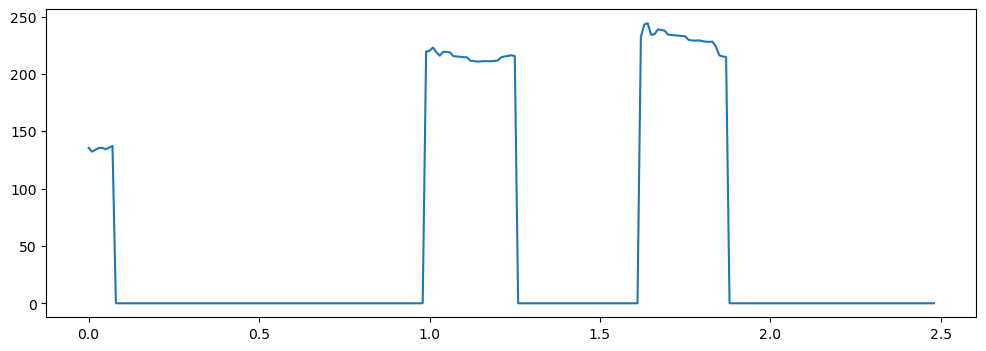

Features from F0:
Mean: 51.76644479473558
Std: 92.16685962797015
10th-percentile: 0.0
90th-percentile: 219.60425158045447
Kurtosis: -0.32758005245094113


In [6]:
import numpy as np
import scipy.io as sio
from scipy import signal
import scipy
from f0_lib import get_f0

# 1. Extract the F0 contour
f0,_,_,_ = get_f0(speech_resampled, fs_down, 0.01)

time_vector_f0 = np.arange(len(f0)) * 0.01

# 2. Visualize the F0 contour
plt.figure(figsize=(12, 4))
plt.plot(time_vector_f0, f0)
plt.show()

# 3. Calculate these distribution parameter features
mean_f0 = np.mean(f0)
std_f0 = np.std(f0)
percentile_10_f0 = np.percentile(f0, 10)
percentile_90_f0 = np.percentile(f0, 90)
kurtosis_f0 = kurtosis(f0)

print('Features from F0:')
print('Mean:', mean_f0)
print('Std:', std_f0)
print('10th-percentile:', percentile_10_f0)
print('90th-percentile:', percentile_90_f0)
print('Kurtosis:', kurtosis_f0)

### Task 1.4. Extract the Rhythm/Durations parameter
**Steps**:
1. Perform a Voiced/Unvoiced speech segmentation of speech signal. Tip: Unvoiced frames are marked with 0 F0 values, you can find the voiced frames (i.e. F0 > 0) using [`numpy.where()`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.where.html).
2. From the segmentation, calculate the means and SDs of both Voiced and Unvoiced segment lengths (i.e. voiced segment mean length, SD of voiced segment lengths, unvoiced segment mean length, SD of unvoiced segment lengths).
3. Calculate also the voicing ratio, i.e. the ratio of voiced segments versus total segments (Tip: You can do this simply by using the frames).



In [7]:
# 1. Segmenting the voiced speech segements.
voiced_inds = np.where(f0 > 0)[0]
diff = voiced_inds[1:] - voiced_inds[: -1]
voiced_to_unvoiced_inds = np.where(diff > 1)[0]
voiced_seg_n = len(voiced_to_unvoiced_inds) + 1
voiced_seg_lengths = np.zeros(voiced_seg_n)
tmp = voiced_inds[0]

for i in range(voiced_seg_n - 1):
    voiced_seg_lengths[i] = voiced_inds[voiced_to_unvoiced_inds[i]] - tmp + 1
    tmp = voiced_inds[voiced_to_unvoiced_inds[i] + 1]
    
voiced_seg_lengths[-1] = voiced_inds[-1] - tmp + 1
# voiced_lengths = sum(voiced_seg_lengths) * 0.01

######################################################
######################################################

# 2. Segmenting unvoiced speech segements.
# hint: similar to the code above. consider f0.
unvoiced_inds = np.where(f0 == 0)[0]
diff = unvoiced_inds[1:] - unvoiced_inds[:-1]
unvoiced_to_voiced_inds = np.where(diff > 1)[0]
unvoiced_seg_n = len(unvoiced_to_voiced_inds) + 1
unvoiced_seg_lengths = np.zeros(unvoiced_seg_n)
tmp = unvoiced_inds[0]

for i in range(unvoiced_seg_n - 1):
    unvoiced_seg_lengths[i] = unvoiced_inds[unvoiced_to_voiced_inds[i]] - tmp + 1
    tmp = unvoiced_inds[unvoiced_to_voiced_inds[i] + 1]

unvoiced_seg_lengths[-1] = unvoiced_inds[-1] - tmp + 1
# unvoiced_lengths = sum(unvoiced_seg_lengths) * 0.01

# 2. Calculate the means and SDs of both Voiced and Unvoiced segment lengths
mean_voiced = np.mean(voiced_seg_lengths)
mean_unvoiced = np.mean(unvoiced_seg_lengths)
std_voiced = np.std(voiced_seg_lengths)
std_unvoiced = np.std(unvoiced_seg_lengths)

print('Features from F0:')
print("Mean of voiced:", mean_voiced)
print("Mean of unvoiced:", mean_unvoiced)

print("Std of voiced:", std_voiced)
print("Std of unvoiced:", std_unvoiced)

# 3. Calculate the voicing ratio.
total_duration = len(f0) * 0.01  # Total duration in seconds
voiced_duration = sum(voiced_seg_lengths) * 0.01  # Voiced duration in seconds

voicing_ratio = voiced_duration / total_duration

print("Voicing Ratio:", voicing_ratio)

Features from F0:
Mean of voiced: 20.333333333333332
Mean of unvoiced: 62.666666666666664
Std of voiced: 8.73053390247253
Std of unvoiced: 22.48456260538674
Voicing Ratio: 0.24497991967871482


### Question 3. What is the difference between voiced and unvoiced sounds? Give some examples of each.

### Your answer:

The voiced and unvoiced sounds differ in terms of the vibration of the vocal cords and the resulting acoustic characteristics.

`Voiced Sounds`: Sing, Dog, Bed etc. \
`Unvoiced Sounds`: Cat, Kite, Shoe etc.


## Task 2. Speech Emotion Classification

In this part, the [`sklearn.svm`](http://scikit-learn.org/stable/modules/svm.html) library is used to perform the speech signal classification. The **‘training_data_proso’** and **‘training_data_mfcc’** matrices contain the calculated prosodic features for the training set (9 features in each row representing a speech sample) and MFCC derived features (12 features) respectively. The **‘training_class’** group vector contains the class of samples: 1 = happy, 2 = sad; corresponding to the rows of the training data matrices.

<!---
Test the classifiers and plot confusion matrices.
* Use the ‘svmclassify’ function (and your trained SVM structures) to classify the ‘training_data_*’ and the ‘testing_data_*’ data matrices. Then, calculate average classification performances for both training and testing data. The correct class labels corresponding with the rows of the training and testing data matrices are in the variables ‘training_class’ and ‘testing_class’, respectively.
    * 	Calculate the average classification performances for the training data (‘training_data_proso’ and ‘training_data_mfcc’) using the corresponding prosody and MFCC trained SVMs.
    * 	Calculate the average classification performance for the testing data (‘testing_data_proso’ and testing_data_mfcc’) using the corresponding prosody and MFCC trained SVMs.
* Plot confusion matrices for the training and testing data for both classifiers. Tip, use ‘confusionmat’ function.-->



<!---speech_sample
testing_class
testing_data_mfcc
testing_data_proso
testing_personID
training_class
training_data_mfcc
training_data_proso
training_personID
### Task 2.1. Preparing your data
Dictionaries of the data are listed below:
* speech_sample
* testing_class
* testing_data_mfcc
* testing_data_proso
* testing_personID
* training_class
* training_data_mfcc
* training_data_proso
* training_personID
Use [`scipy.io.loadmat()`] to read the dataset.-->

### Task 2.1. Train the SVM classifiers
**Steps**:
1. Load the training data.
2. Train a SVM with the prosody data using the **‘training_data_proso’** features and a **3rd order polynomial** kernel.
3. Train a SVM with the MFCC data using the **‘training_data_mfcc’** features and a **3rd order polynomial** kernel.

In [8]:
# Initialize the SVM classifiers.
from sklearn import svm

# 1. Load data
exercise_data = sio.loadmat('lab2_data.mat')

#    1.1 Load 'training_data_proso'
training_data_proso = exercise_data['training_data_proso']

#    1.2 Load 'training_data_mfcc'
training_data_mfcc = exercise_data['training_data_mfcc']

#    1.3 Load 'training_class'
training_class = exercise_data['training_class'].reshape(-1)

# 2. Train a classifier using the prodosic data
#    2.1 Initialize a svm classifer
svm_proso = svm.SVC(kernel='poly', degree=3)

#    2.2 Train the classifier
svm_proso.fit(training_data_proso, training_class)

# 3. Train a classifer using the mfcc data
#    2.1 Initialize a svm classifer
svm_mfcc = svm.SVC(kernel='poly', degree=3)

#    2.2 Train the classifier
svm_mfcc.fit(training_data_mfcc, training_class)

SVC(kernel='poly')

### Task 2.2. Test the classifiers
Classify the **‘training_data_*’** and the **‘testing_data_*’** data matrices. Then, calculate average classification performances for both training and testing data. The correct class labels corresponding with the rows of the training and testing data matrices are in the variables ‘training_class’ and ‘testing_class’, respectively.

**Steps**:
1. Load the testing data.
2. Calculate the average classification accuracy for the training data (**‘training_data_proso’** and **‘training_data_mfcc’**) using the corresponding prosody and MFCC trained SVMs.
3. Calculate the average classification accuracy for the testing data (**‘testing_data_proso’** and **‘testing_data_mfcc’**) using the corresponding prosody and MFCC trained SVMs.
4. Print the four accuracies you have calculated.

In [9]:
from sklearn.metrics import accuracy_score

# 1. Load testing data
testing_data_mfcc = exercise_data['testing_data_mfcc']
testing_data_proso = exercise_data['testing_data_proso']
testing_class = exercise_data['testing_class'].reshape(-1)

# 2. Calculate the average classification performances for the training data
train_proso_predictions = svm_proso.predict(training_data_proso)
train_mfcc_predictions = svm_mfcc.predict(training_data_mfcc)

train_proso_accuracy = accuracy_score(training_class, train_proso_predictions)
train_mfcc_accuracy = accuracy_score(training_class, train_mfcc_predictions)

# 3. Calculate the average classification performance for the testing data
test_proso_predictions = svm_proso.predict(testing_data_proso)
test_mfcc_predictions = svm_mfcc.predict(testing_data_mfcc)

test_proso_accuracy = accuracy_score(testing_class, test_proso_predictions)
test_mfcc_accuracy = accuracy_score(testing_class, test_mfcc_predictions)

# 4. Print the four accuracies.
print(train_proso_accuracy)
print(train_mfcc_accuracy)
print(test_proso_accuracy)
print(test_mfcc_accuracy)

0.84
0.96
0.62
0.84


### Question 4. Which one of the extracted features performed better?

### Your answer:

The MFCC features performed better in both the training and testing datasets.

### Task 2.3. Plot confusion matrices for the training and testing data for both classifiers. 
Print following confusion matrix(Tip, use [`sklearn.metrics.confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function):
* The confusion matrix of the prosody trained SVM using the **‘training_data_proso’**.
* The confusion matrix of the prosody trained SVM using the **‘testing_data_proso’**.
* The confusion matrix of the MFCC trained SVM using the **‘training_data_mfcc’**.
* The confusion matrix of the MFCC trained SVM using the **‘testing_data_mfcc’**.

In [10]:
from sklearn.metrics import confusion_matrix

train_proso_confusion = confusion_matrix(training_class, train_proso_predictions)
train_mfcc_confusion = confusion_matrix(training_class, train_mfcc_predictions)

test_proso_confusion = confusion_matrix(testing_class, test_proso_predictions)
test_mfcc_confusion = confusion_matrix(testing_class, test_mfcc_predictions)

print(train_proso_confusion)
print(train_mfcc_confusion)
print(test_proso_confusion)
print(test_mfcc_confusion)

[[17  8]
 [ 0 25]]
[[23  2]
 [ 0 25]]
[[ 9 16]
 [ 3 22]]
[[22  3]
 [ 5 20]]


### Question 5. What can you conclude from the confusion matrices?

### Your answer:

For the training data, both the Prosody and MFCC classifiers perform very well on the training data, achieving high accuracy. This suggests that both classifiers have learned to fit the training data effectively. Whereas, for the testing data, the MFCC classifier outperforms the Prosody classifier on the testing data in terms of overall accuracy. The Prosody classifier has a higher number of false positives compared to the MFCC classifier. The MFCC classifier has a higher number of false negatives compared to the Prosody classifier.

Overall, the MFCC classifier has better performance on unseen/testing data compared to the Prosody classifier.

### Question 6. Can you proposed other classification metrics? Please give explanations of your proposed metrics.

### Your answer:

1. `Precision`: It measures the proportion of true positive predictions among all positive predictions made by the classifier. High precision indicates that the classifier makes fewer false positive errors.
2. `Recall`: It measures the proportion of true positive predictions among all actual positive instances. High recall indicates that the classifier captures a larger portion of the positive instances.
3. `F1-Score`: It combines precision and recall into a single score. It ranges from 0 to 1. A high F1-Score indicates that the classifier has both high precision and high recall. A low F1-Score indicates that the classifier either has low precision, low recall or both.
4. `Specificity`: It measures the proportion of true negative predictions among all actual negative instances. High specificity indicates that the classifier makes fewer false positive errors for the negative class.
5. `ROC Curve`: It is a graphical representation of classifier performance across different threshold values. The area under the ROC curve, **AUC-ROC** is a single scalar value that summarizes classifier performance. A higher AUC-ROC indicates better overall performance.
6. `Specificity`: It measures the proportion of true negative predictions among all actual negative instances.